In [22]:
%load_ext autoreload
%autoreload 2

import splitwavepy as sw
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


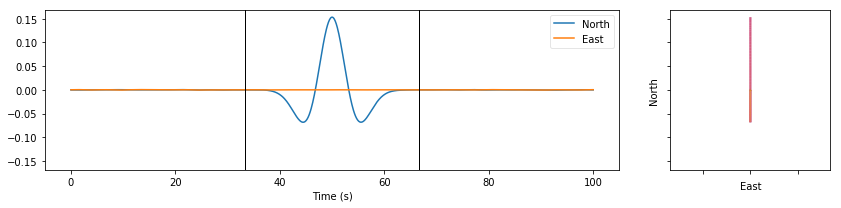

In [2]:
a = sw.SplitWave()
a.plot()

In [3]:
b = a.Py()

In [39]:
def plot(self, **kwargs):
    # setup figure and subplots
    fig = plt.figure(figsize=(12,6)) 

    gs = gridspec.GridSpec(3, 3, 
                           width_ratios=[2,1,3])
    ax0 = plt.subplot(gs[0,0:2])                     
    ax1 = plt.subplot(gs[1,0])
    ax2 = plt.subplot(gs[1,1])
    ax3 = plt.subplot(gs[2,0])
    ax4 = plt.subplot(gs[2,1])
    ax5 = plt.subplot(gs[:,2])

    orig = self.srcpoldata().chop()
    corr = self.srcpoldata_corr().chop()

    # get axis scaling
    lim = np.abs(corr._xy.max()) * 1.1
    ylim = [-lim, lim]

    # long window data
    self._ptr(ax0, ylim=ylim, **kwargs)

    # original
    orig._ptr(ax1, ylim=ylim, **kwargs)
    orig._ppm(ax2, lims=ylim, **kwargs)

    # corrected
    corr._ptr(ax3, ylim=ylim, **kwargs)
    corr._ppm(ax4, lims=ylim, **kwargs)

In [40]:
plot(b)


AttributeError: 'Py' object has no attribute '_SplitWave__t0'

In [27]:
b.sc

{'fast': 88.0,
 'lag': 0.0,
 'lam1': array([[ 0.00099631,  0.00101189,  0.00102881, ...,  0.00099897,
          0.00099744,  0.00099651],
        [ 0.0009963 ,  0.00101189,  0.00102878, ...,  0.00099896,
          0.00099744,  0.00099651],
        [ 0.00099629,  0.00101184,  0.00102867, ...,  0.00099894,
          0.00099743,  0.00099651],
        ..., 
        [ 0.0009962 ,  0.00100172,  0.00100814, ...,  0.00099663,
          0.00099639,  0.00099624],
        [ 0.00099619,  0.00100143,  0.00100754, ...,  0.00099659,
          0.00099637,  0.00099624],
        [ 0.00099619,  0.00100114,  0.00100693, ...,  0.00099655,
          0.00099635,  0.00099623]]),
 'lam2': array([[  9.94048227e-04,   9.78178675e-04,   9.60373630e-04, ...,
           3.22248309e-08,   2.90325289e-08,   2.93928976e-08],
        [  9.94054723e-04,   9.78186790e-04,   9.60403016e-04, ...,
           4.03303992e-08,   3.29770274e-08,   3.06335976e-08],
        [  9.94061794e-04,   9.78235911e-04,   9.60515905e-04, .

In [13]:
bc = b._data.copy()
# bc = bc.unsplit(10,0)
# bc.plot()

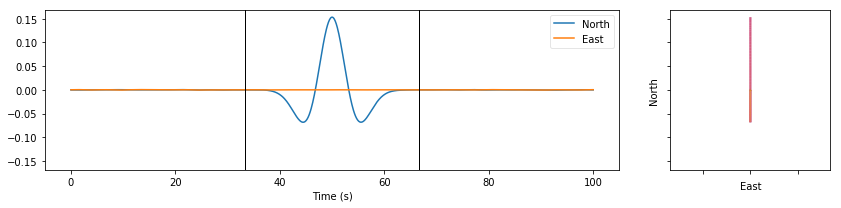

In [16]:
bc.unsplit(10,0).plot()

In [42]:
b = a.Py()

/Users/jackwalpole/Applications/splitwavepy/splitwavepy/core/core.py:527: RuntimeWarning: invalid value encountered in double_scalars
  delta = lagxc / lagsc


In [43]:
b.report()

    SCfast   SCdfast     SClag    SCdlag    XCfast   XCdfast     XClag    XCdlag         Q
     88.00      0.00      0.00      0.00     86.00      0.00      0.00      0.00       nan


In [45]:
cov = sw.core.core.gridcovfreq(a.x, a.y, b._ndegs, 83)

In [232]:
b._grid

AttributeError: 'Py' object has no attribute '_Py__nslags'

In [63]:
def covfreq_reshape(cov):
    """Reshape a covariance map output using the Fourier method to match the standard."""
    shp = cov.shape
    mid = int((shp[0]-1)/2)
    neg = np.flip(cov[:mid+1,:,:,:], 1)
#     neg = cov[:mid+1,:,:,:]
    pos = cov[mid:,:,:,:]
    return np.concatenate((neg, pos), axis=1)    

In [64]:
covrs = covfreq_reshape(cov)

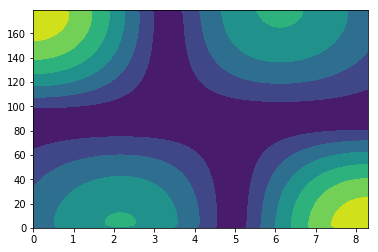

In [65]:
dd, ll = b._grid
rho = np.abs(sw.core.core.covmap2rho(covrs))
plt.contourf(ll, dd, rho)
plt.show()

In [74]:
x = a.x
y = a.y
fx = np.fft.fft(x)
fy = np.fft.fft(y)

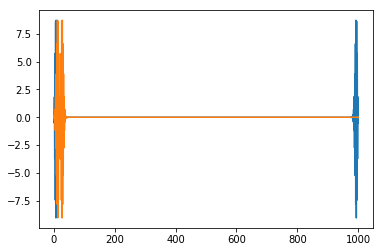

In [79]:
# plt.plot(np.fft.fftshift(fx))
plt.plot(fx.real)
plt.plot(np.roll(fx.real, 20))
plt.show()

/Users/jackwalpole/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


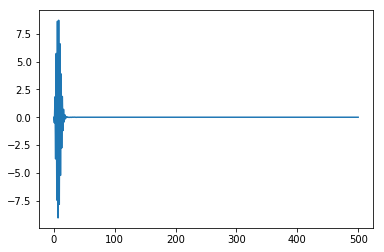

In [73]:
plt.plot(fx)
# plt.plot(fx)
plt.show()

In [108]:
rotate = sw.core.core.rotate

def gridcovfreq(x, y, ndegs=90, nslags=50):
    """Returns grid of covariance matrices of shape (ndegs/2, (2*nslags)-1, 2, 2).
       Use covfreq_reshape to get this into a more user friendly shape.
       x and y are the windowed traces.  
       Probably best to use a reasonably long, tapered, window as shifts
       are performed implicitly in the Frequency domain (so wrap around?).
    """
    mdegs = int(ndegs/2)
    mlags = int(nslags*2) - 1
    degs = np.linspace(0, 90, mdegs, endpoint=False)
    n = x.size
    g = np.empty((mlags, mdegs, 2, 2))
    # Fourier Transform
    fx = np.fft.fft(x)
    fy = np.fft.fft(y)
    fx[0] = 0
    fy[0] = 0
    sumsqrs = np.sum(np.abs(fx)**2 + np.abs(fy)**2)
    # now loop and calculate
    for ii in range(mdegs):
        # rotate
        fxr, fyr = rotate(fx, fy, degs[ii])
        # correlate
        cxy = fxr * fyr.conj()
        # inverse transform
        icxy = np.fft.ifft(cxy).real
        # get info
        sumxsqr = np.sum(np.abs(fxr)**2) / n
        sumysqr = (sumsqrs-sumxsqr) / n
        covxy = np.roll(icxy, int(nslags)-1)[0:mlags]
        # basic covariance map
        g[:,ii,0,0] = sumxsqr
        g[:,ii,1,1] = sumysqr
        g[:,ii,0,1] = g[:,ii,1,0] = covxy
    return g / n

In [228]:
a = sw.SplitWave(noise=0.001, split=(30,1.2))
cov = gridcovfreq(a.x, a.y)
cov.shape

(99, 45, 2, 2)

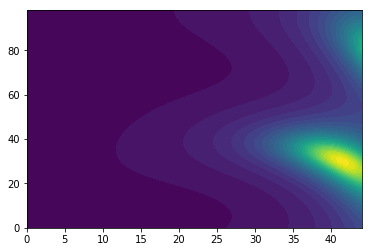

array([[ 0,  1,  2, ..., 42, 43, 44],
       [ 0,  1,  2, ..., 42, 43, 44],
       [ 0,  1,  2, ..., 42, 43, 44],
       ..., 
       [ 0,  1,  2, ..., 42, 43, 44],
       [ 0,  1,  2, ..., 42, 43, 44],
       [ 0,  1,  2, ..., 42, 43, 44]])

In [242]:
shp = cov.shape
aa, bb = np.meshgrid(np.arange(shp[0]), np.arange(shp[1]), indexing='ij')
# aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))
rho = sw.core.core.covmap2rho(cov)
lam1, lam2 = sw.core.core.covmap2eigvals(cov)
plt.contourf(bb, aa, lam1/lam2, 30)
plt.show()
bb


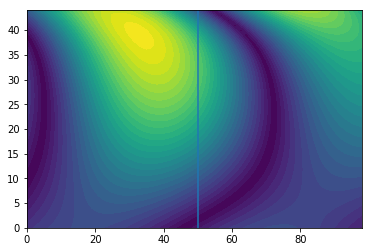

In [237]:
shp = cov.shape
aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))
# stdy = np.sqrt(cov[:, :, 1, 1])
# stdx = np.sqrt(cov[:, :, 0, 0])
# rho = c[:,:,0,1] / (np.sqrt(c[:, :, 1, 1]) * np.sqrt(c[:, :, 0, 0]))
# rho = cov[:,:,0,1] / (stdx * stdy)
rho = sw.core.core.covmap2rho(cov)
plt.contourf(bb, aa, np.abs(rho), 30)
plt.axvline(50)
plt.show()


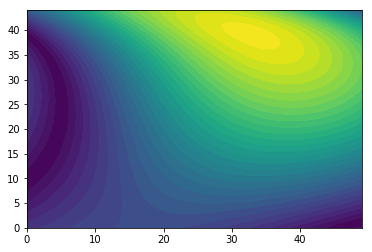

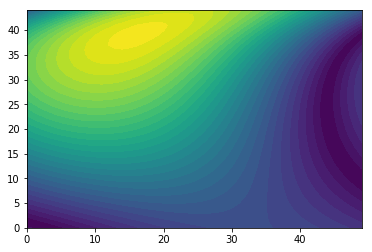

In [236]:
shp = cov.shape
mid = int((shp[0]-1)/2)
pos = cov[:mid+1,:,:,:]
# pos = np.flip(pos, 0)
neg = cov[mid:,:,:,:]
rs = np.concatenate((neg, pos), axis=1)

lam1, lam2 = sw.core.core.covmap2eigvals(pos)
rho = sw.core.core.covmap2rho(pos)
shp = pos.shape
aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))
# plt.contourf(bb, aa, lam1/lam2, 30)
plt.contourf(bb, aa, np.abs(rho), 30)
plt.show()

pos = np.flip(pos, 0)
lam1, lam2 = sw.core.core.covmap2eigvals(pos)
rho = sw.core.core.covmap2rho(pos)
shp = pos.shape
aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))
# plt.contourf(bb, aa, lam1/lam2, 30)
plt.contourf(bb, aa, np.abs(rho), 30)
plt.show()

# lam1, lam2 = sw.core.core.covmap2eigvals(neg)
# rho = sw.core.core.covmap2rho(neg)
# shp = neg.shape
# aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))
# # plt.contourf(bb, aa, lam1/lam2, 30)
# plt.contourf(bb, aa, np.abs(rho), 30)
# plt.show()

# aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))
# plt.contourf(bb, aa, lam1/lam2, 30)
# plt.show()

# shp = rs.shape
# aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))
# rho = sw.core.core.covmap2rho(rs)
# plt.contourf(bb, aa, np.abs(rho), 30)
# plt.show()

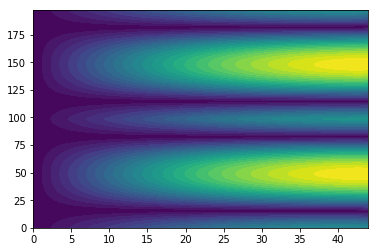

In [225]:
rho = sw.core.core.covmap2rho(cov)
rho2 = np.concatenate((np.flip(rho,0), rho),0)

shp = rho2.shape
aa, bb = np.meshgrid(np.arange(shp[1]), np.arange(shp[0]))

plt.contourf(aa, bb, np.abs(rho2), 30)
plt.show()

In [101]:
shp

(50, 90, 2, 2)

In [153]:
sw.core.core.covmap2rho??

(45, 99, 2, 2)

In [244]:
lags = np.arange(10) * 0.1
degs = np.linspace(0,180,90,endpoint=False)
xx, yy = np.meshgrid(lags, degs, indexing='ij')

In [248]:
xx.shape

(10, 90)